In [2]:
import pandas as pd 
from datetime import datetime 
from datetime import date
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.callbacks import ModelCheckpoint

dataPATH = r"C:\Users\levim\OneDrive\Documents\MastersAI_ES\TeamProject-5ARIP10\smart-buildings\Data"
all_data = pd.read_csv(dataPATH + r"\long_merge.csv")

c:\Users\levim\anaconda3\envs\experiments\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Prepar energy data set with extended features
feature_list = ['date', 'hvac_N', 'hvac_S', 'air_temp_set_1', 'solar_radiation_set_1']
extended_energy_data = all_data[feature_list]

extended_energy_data['date'] = pd.to_datetime(extended_energy_data['date'])
extended_energy_data.set_index('date', inplace=True)

eed_15m = extended_energy_data.resample('15T').mean()
eed_15m = eed_15m.reset_index(drop=False)

window_size = 12*4 # Half a day
eed_15m_avg = eed_15m.copy()
eed_15m_avg['hvac_N'] = eed_15m['hvac_N'].rolling(window=window_size).mean()
eed_15m_avg['hvac_S'] = eed_15m['hvac_S'].rolling(window=window_size).mean()

eed_15m.head()

NameError: name 'all_data' is not defined

In [17]:
# energy_data = pd.read_csv(dataPATH + r"\hvac_data_1h.csv")
# energy_data = eed_15m
energy_data = eed_15m_avg

# Convert the date column to datetime
energy_data['date'] = pd.to_datetime(energy_data['date'], format = "%Y-%m-%d %H:%M:%S")

energy_data['day_of_week'] = energy_data['date'].dt.weekday
# Filter the data for the year 2019
df_filtered = energy_data[ (energy_data.date.dt.date >date(2019, 1, 20)) & (energy_data.date.dt.date< date(2019, 7, 26))]

# Check for NA values in the DataFrame
if df_filtered.isna().any().any():
    print("There are NA values in the DataFrame columns.")

In [18]:
testdataset_df = df_filtered[(df_filtered.date.dt.date <date(2019, 2, 20))]

traindataset_df = df_filtered[ (df_filtered.date.dt.date >date(2019, 2, 21))]

testdataset = testdataset_df.drop(columns=["date"]).values

traindataset = traindataset_df.drop(columns=["date"]).values

columns_with_na = traindataset_df.columns[traindataset_df.isna().any()].tolist()
columns_with_na

[]

In [19]:
traindataset = traindataset.astype('float32')
testdataset = testdataset.astype('float32')

mintest = np.min(testdataset[:,0:2])
maxtest = np.max(testdataset[:,0:2])

scaler = MinMaxScaler(feature_range=(0, 1))
traindataset = scaler.fit_transform(traindataset)
testdataset = scaler.transform(testdataset)

In [20]:
train,test = traindataset,testdataset
steps_in_past   = 3   
time_step       = 4*8
no_inputs       = 5
no_outputs      = 2
def create_dataset(dataset,time_step):
    x = [[] for _ in range(no_inputs)] 
    Y = [[] for _ in range(no_outputs)]
    for i in range(time_step * steps_in_past, len(dataset) - time_step * steps_in_past): # -time_step is to ensure that the Y value has enough values
        for j in range(no_inputs):
            x[j].append(dataset[(i-time_step*steps_in_past):i, j])
        for j in range(no_outputs):
            Y[j].append([dataset[x + i, j] for x in range(0,time_step)])    
    x = [np.array(feature_list) for feature_list in x]
    x = np.stack(x,axis=2)
    Y = [np.array(feature_list) for feature_list in Y] 
    Y = np.stack(Y,axis=2)
    Y = np.reshape(Y, (Y.shape[0], time_step*no_outputs))
    return x, Y


X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=time_step*no_outputs))

model.compile(optimizer='adam', loss='mean_squared_error')

checkpoint_path = "lstm_energy_01.keras"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/5
56/56 [==============================] - ETA: 0s - loss: 0.0359
Epoch 1: val_loss improved from inf to 0.02863, saving model to lstm_energy_01.keras
56/56 [==============================] - 14s 157ms/step - loss: 0.0359 - val_loss: 0.0286
Epoch 2/5
56/56 [==============================] - ETA: 0s - loss: 0.0185
Epoch 2: val_loss improved from 0.02863 to 0.02514, saving model to lstm_energy_01.keras
56/56 [==============================] - 8s 138ms/step - loss: 0.0185 - val_loss: 0.0251
Epoch 3/5
56/56 [==============================] - ETA: 0s - loss: 0.0170
Epoch 3: val_loss improved from 0.02514 to 0.02490, saving model to lstm_energy_01.keras
56/56 [==============================] - 8s 142ms/step - loss: 0.0170 - val_loss: 0.0249
Epoch 4/5
56/56 [==============================] - ETA: 0s - loss: 0.0159
Epoch 4: val_loss did not improve from 0.02490
56/56 [==============================] - 8s 141ms/step - loss: 0.0159 - val_loss: 0.0278
Epoch 5/5
56/56 [====================

In [ ]:
# Autoregressive prediction
X_pred = testdataset.copy()
for i in range(steps_in_past,steps_in_past*2):
    xin = X_pred[i-steps_in_past:i].reshape((1, steps_in_past, no_outputs)) 
    X_pred[i] = model.predict(xin, verbose = 0)

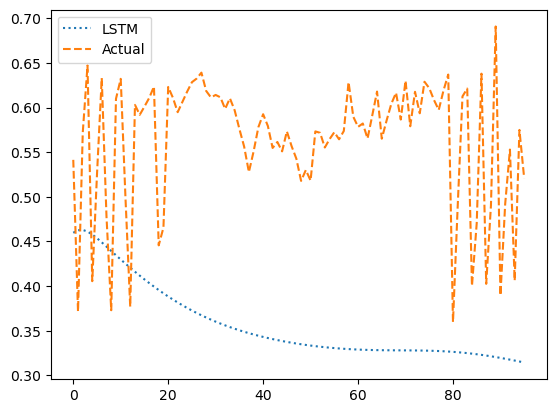

In [54]:
# Plot prediction vs actual for test data
plt.figure()
plt.plot(X_pred[steps_in_past:steps_in_past*2,0],':',label='LSTM')
plt.plot(testdataset[steps_in_past:steps_in_past*2,0],'--',label='Actual')
plt.legend()

In [ ]:
test = model.predict(X_test[0].reshape((1,X_test.shape[1],X_test.shape[2])))
test

In [21]:
loss            = model.evaluate(X_test, y_test)
test_predict1   = model.predict(X_test)
print("Loss: ", loss)
# Converting values back to the original scale
scalerBack      = MinMaxScaler(feature_range=(mintest, maxtest))
test_predict2   = scalerBack.fit_transform(test_predict1)
y_test1         = scalerBack.fit_transform(y_test)


18/18 [==============================] - 2s 32ms/step
Loss:  0.02554473653435707


In [22]:
%matplotlib qt

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop over the value index
for i, ax in enumerate(axes.flat):
    # Plot your data or perform any other operations
    ax.plot(y_test[i,0:time_step], label='Original Testing Data', color='blue')
    ax.plot(test_predict1[i,0:time_step], label='Predicted Testing Data', color='red',alpha=0.8)
    # ax.set_title(f'Plot {i+1}')
    ax.set_title('Testing Data - Predicted vs Actual')
    ax.set_xlabel('Time [hours]')
    ax.set_ylabel('Energy Consumption [kW]')     
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
plt.plot(testdataset_df['date'], testdataset_df['hvac_N'], alpha = 0.8, label='Original Testing Data', color='blue')
plt.plot(test_predict2[])
plt.show()


In [ ]:
y_test[1, 0:24]

In [ ]:
maxtest